Import packages and functions

In [1]:
import sys
sys.path.append('../../../')


In [2]:
from scripts.forecast import DataGenerator, make_photoz_bin_edges, compare_fisher_matrices
from scripts.luminosity_functions import def_clusters_xlf, ClustersXrayLuminosityFunction, ccl, def_cosmo
import matplotlib
from scripts.utils import np, plt, set_mpl
set_mpl()
%matplotlib inline


Set up parameters of cluster population

In [3]:
fiducial_params = {'Omega_c': 0.25, 'Omega_b': 0.05,
                   'h': 0.7, 'sigma8': 0.8, 'n_s': 0.96,
                   'transfer_function': 'boltzmann_camb',
                   'baryons_power_spectrum': 'nobaryons',
                   'matter_power_spectrum': 'linear'}

fsky = 0.658
powspec_pars_dict_clu = {
    'slim': 4.4e-14,
    'l_min': 10,
    'l_max': 150,
    'log_bins': 41,
    'fsky': fsky,
    'has_rsd': True,
    'density_multiplier': 1.0,
    'camb_llimber': 110,
    'xlf': def_clusters_xlf,
    'use_camb': True,
    'delta_i': 3,
    'remove_ignored_cells': True,
}



zmin_clu = 0.1
zmax_clu = 0.8
sigma0_clu = 0.01
f_fail_clu = 0.02
bins_clu = make_photoz_bin_edges(zmin_clu, zmax_clu, k=1, sigma_0=sigma0_clu)

powspec_pars_dict_clu['sigma_0'] = sigma0_clu
powspec_pars_dict_clu['f_fail'] = f_fail_clu

Run DataGenerator object to generate dndz, Cell, etc

Total Clusters sources: 87338 at fsky=0.658[27144 deg^2]
Photo-z parameters: self.sigma_0=0.01, self.f_fail=0.02
calculating CAMB...
CAMB calculation time: 9.176989793777466


calc Covariance: 100%|██████████| 1275/1275 [00:15<00:00, 84.47it/s] 


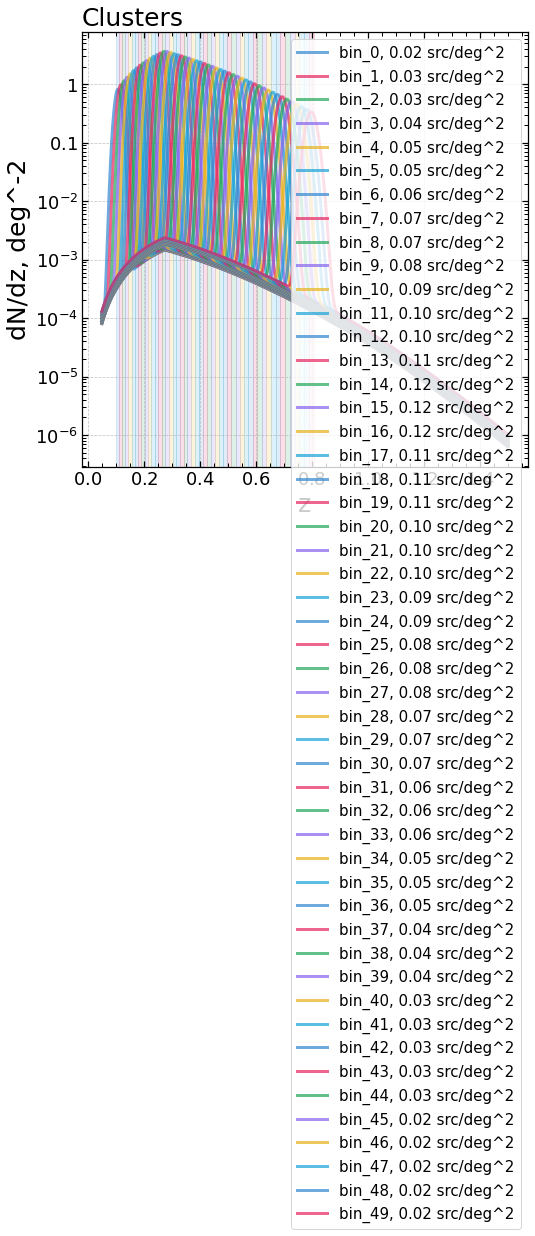

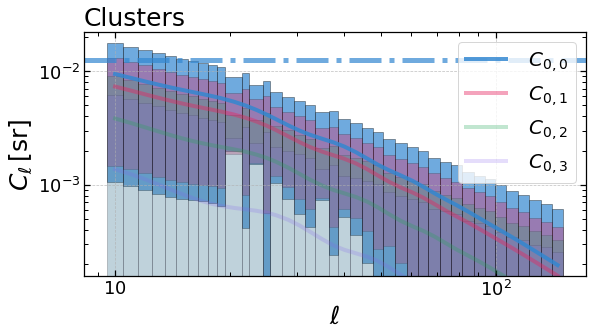

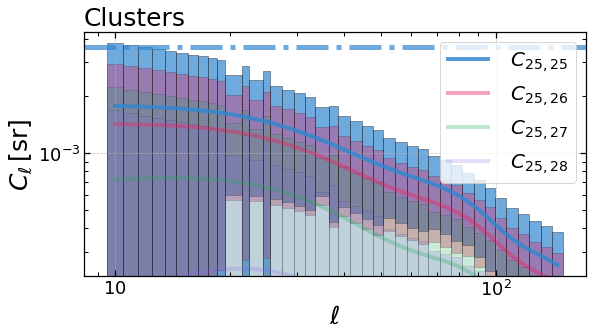

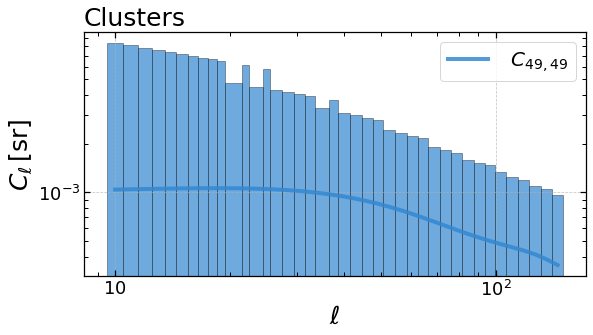

In [4]:
datagen_clu = DataGenerator(
                                 fiducial_params=fiducial_params, set_name = 'Clusters')

datagen_clu.invoke(**powspec_pars_dict_clu, bin_left_edges=bins_clu, plot_dndz=True, plot_cell=True);
datagen_clu.invert_cov();

Calculate the Fisher matrix

In [5]:
F = datagen_clu.get_Fisher_matrix(jac_step = 0.001, jac_order = 2)[0]

Start Jacobian calculation (cosmological part): jac_step=0.001, jac_order=2
Finished Jacobian calculation (cosmological part) in 114.00 seconds


Plot the Fisher matrix


Clusters
FoM: 2.64e+08
Omega_c: 0.250 +- 0.034 (13.4 %)
Omega_b: 0.050 +- 0.041 (81.8 %)
h: 0.700 +- 0.512 (73.2 %)
n_s: 0.960 +- 0.351 (36.6 %)
sigma_8: 0.800 +- 0.012 (1.4 %)
-------


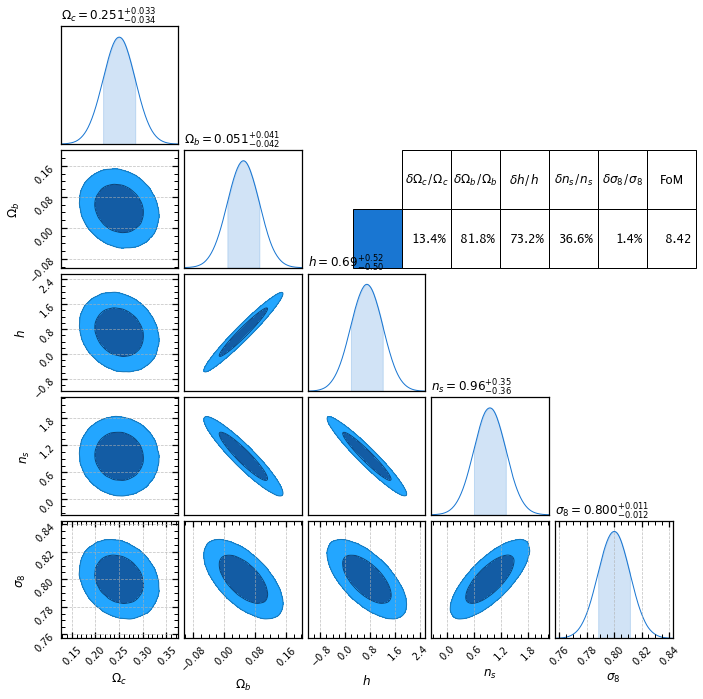

In [6]:
compare_fisher_matrices([F]);

# Modify ML relation for cluster XLF

In [8]:
# class ClustersXrayLuminosityFunction_new(ClustersXrayLuminosityFunction):

#     def ML(self, M500: float, z: np.ndarray) -> np.ndarray:
#         """
#         ML is a Mass-Luminosity relation from Reichert et al. (2011)
#         M500 - Mass is in units of Msun/h (M500c)
#         z - redshift
#         """
#         a = 1/(1+z)
#         E = ccl.background.h_over_h0(self.cosmo, a=a)
#         h = self.cosmo['h']
#         Lx = 1e44* (M500/1e14 * 0.61)**1.92 * E**1.7
#         return Lx

#     def LM(self, L: float, z: np.ndarray) -> np.ndarray:
#         """
#         LM - this is the inverse of function ML
#         """
#         a = 1/(1+z)
#         E = ccl.background.h_over_h0(self.cosmo, a=a)
#         h = self.cosmo['h']
#         M500 =  ( L/(1e44*E**1.7) )**(1/1.92) * 1e14/0.61
#         return M500

#     def MT(self, M500: float, z: float) -> float:
#         """
#         MT mass-temperature relation from Reichert et al. (2011)

#         Args:
#             M500 (float): Mass, M500c in units of Msun/h
#             z (float): redshift
#             a_tm (float, optional): parameter. Defaults to 0.65.
#             b_tm (float, optional): parameter. Defaults to 3.02*1e14.

#         Returns:
#             float: Temperature for a given mass and redshift
#         """

#         a = 1/(1+z)
#         E = ccl.background.h_over_h0(self.cosmo, a=a)
#         h = self.cosmo['h']
#         T = (M500/1e14 * 3.44)**0.62 * E**0.64
#         return T



class ClustersXrayLuminosityFunction_new(ClustersXrayLuminosityFunction):

    def ML(self, M500: float, z: np.ndarray) -> np.ndarray:
        """
        ML is a Mass-Luminosity relation from Mantz 2010 (https://ui.adsabs.harvard.edu/abs/2010MNRAS.406.1773M/abstract)
        """
        a = 1/(1+z)
        E = ccl.background.h_over_h0(self.cosmo, a=a)
        h = self.cosmo['h']
        m = np.log10(E*M500/1e15)
        Lx = E  *1e44 *  10 ** ( (1.23 + 1.63*m)  )
        return Lx


    def LM(self, L: float, z: np.ndarray) -> np.ndarray:
        """
        LM - this is the inverse of function ML
        """
        a = 1/(1+z)
        E = ccl.background.h_over_h0(self.cosmo, a=a)
        
        #find m from          Lx = E  *1e44 *  10 ** ( (1.23 + 1.63*m)  )
        logm = (np.log10(L/(E*1e44)) - 1.23)/1.63
        M500 = 10 ** logm  *1e15 / E

        return M500

    def MT(self, M500: float, z: float) -> float:
        """
        MT mass-temperature relation from Reichert et al. (2011)

        Args:
            M500 (float): Mass, M500c in units of Msun/h
            z (float): redshift
            a_tm (float, optional): parameter. Defaults to 0.65.
            b_tm (float, optional): parameter. Defaults to 3.02*1e14.

        Returns:
            float: Temperature for a given mass and redshift
        """

        a = 1/(1+z)
        E = ccl.background.h_over_h0(self.cosmo, a=a)
        m = np.log10(E*M500/1e15)
        T = 10 ** ( 0.88+   0.89*m)
        return T









def_clusters_xlf_new_ML = ClustersXrayLuminosityFunction_new(cosmo=def_cosmo)


In [10]:
def_clusters_xlf_new_ML.MT(2e14, 0.3)

2.0760418428096497

In [9]:
def_clusters_xlf_new_ML.ML(2e14, 0.3)

1.8448925253337633e+44

In [31]:
def_clusters_xlf_new_ML.ML(2e14, 0.3)

1.9015931581936768e+44

In [12]:
fiducial_params = {'Omega_c': 0.25, 'Omega_b': 0.05,
                   'h': 0.7, 'sigma8': 0.8, 'n_s': 0.96,
                   'transfer_function': 'boltzmann_camb',
                   'baryons_power_spectrum': 'nobaryons',
                   'matter_power_spectrum': 'linear'}

fsky = 0.658
powspec_pars_dict_clu_new_ml = {
    'slim': 4.4e-14,
    'l_min': 10,
    'l_max': 150,
    'log_bins': 41,
    'fsky': fsky,
    'has_rsd': True,
    'density_multiplier': 1.0,
    'camb_llimber': 110,
    'xlf': def_clusters_xlf_new_ML,
    'use_camb': True,
    'delta_i': 3,
    'remove_ignored_cells': True,
}



zmin_clu = 0.1
zmax_clu = 0.8
sigma0_clu = 0.01
f_fail_clu = 0.02
bins_clu = make_photoz_bin_edges(zmin_clu, zmax_clu, k=1, sigma_0=sigma0_clu)

powspec_pars_dict_clu_new_ml['sigma_0'] = sigma0_clu
powspec_pars_dict_clu_new_ml['f_fail'] = f_fail_clu

Total Clusters sources: 207688 at fsky=0.658[27144 deg^2]
Photo-z parameters: self.sigma_0=0.01, self.f_fail=0.02
calculating CAMB...


KeyboardInterrupt: 

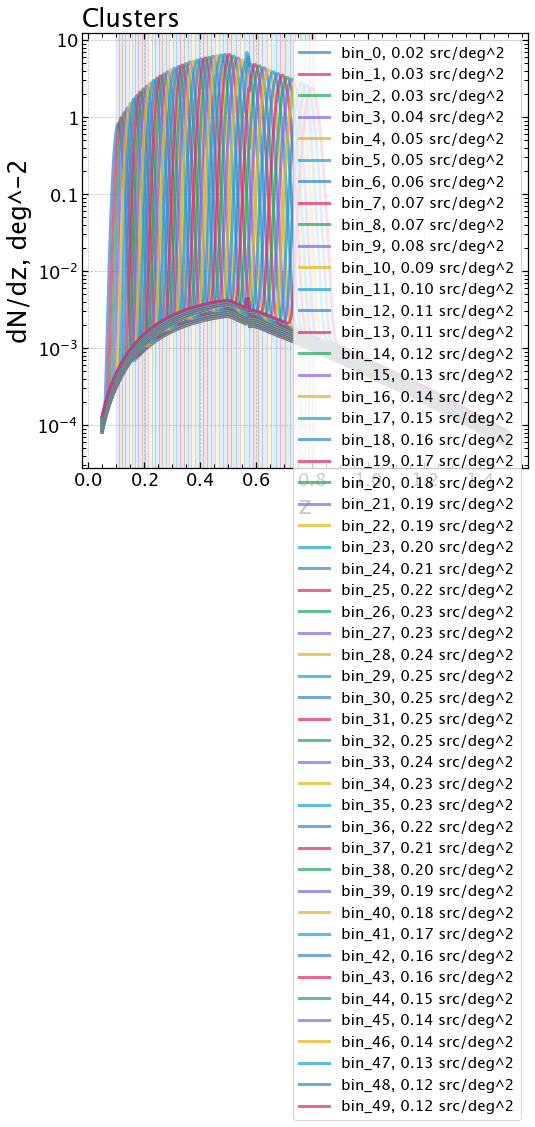

In [13]:
datagen_clu_new_ml = DataGenerator(
                                 fiducial_params=fiducial_params, set_name = 'Clusters')

datagen_clu_new_ml.invoke(**powspec_pars_dict_clu_new_ml, bin_left_edges=bins_clu, plot_dndz=True, plot_cell=True);
datagen_clu_new_ml.invert_cov();

In [43]:
F_new_ml = datagen_clu_new_ml.get_Fisher_matrix(jac_step = 0.001, jac_order = 2)[0]

Start Jacobian calculation (cosmological part): jac_step=0.001, jac_order=2
Finished Jacobian calculation (cosmological part) in 130.61 seconds



Clusters
FoM: 7.81e+07
Omega_c: 0.250 +- 0.043 (17.4 %)
Omega_b: 0.050 +- 0.052 (104.5 %)
h: 0.700 +- 0.659 (94.2 %)
n_s: 0.960 +- 0.450 (46.8 %)
sigma_8: 0.800 +- 0.018 (2.3 %)
-------


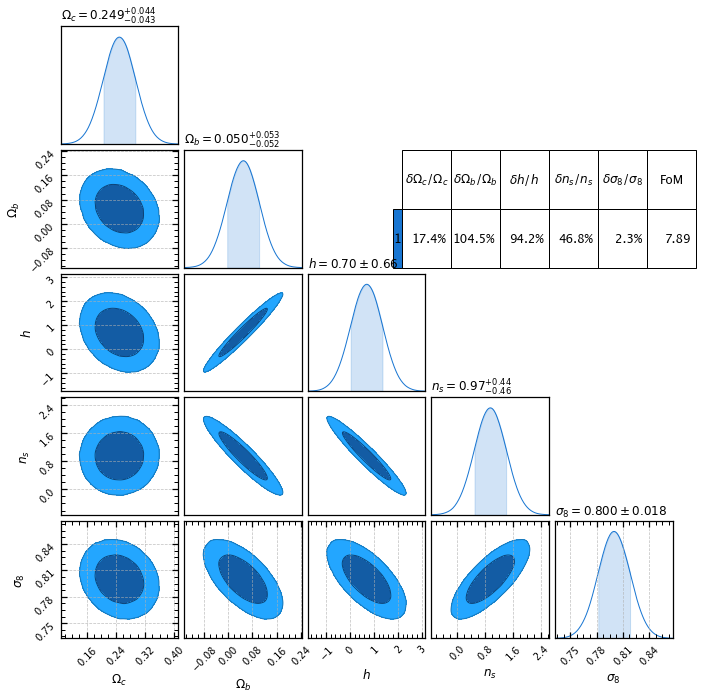

In [44]:
compare_fisher_matrices([F_new_ml]);


#baseline vikhlinin 83k clusters
# Clusters
# FoM: 2.64e+08
# Omega_c: 0.250 +- 0.034 (13.4 %)
# Omega_b: 0.050 +- 0.041 (81.8 %)
# h: 0.700 +- 0.512 (73.2 %)
# n_s: 0.960 +- 0.351 (36.6 %)
# sigma_8: 0.800 +- 0.012 (1.4 %)
# -------
# ======


#Reichert et al. (2011) 186k clusters
# Clusters
# FoM: 1.03e+09
# Omega_c: 0.250 +- 0.026 (10.2 %)
# Omega_b: 0.050 +- 0.031 (62.3 %)
# h: 0.700 +- 0.392 (55.9 %)
# n_s: 0.960 +- 0.270 (28.1 %)
# sigma_8: 0.800 +- 0.010 (1.3 %)


#Reichert et al. (2011) 85k clusters (via multiplication factor)
# Clusters
# FoM: 7.81e+07
# Omega_c: 0.250 +- 0.043 (17.4 %)
# Omega_b: 0.050 +- 0.052 (104.5 %)
# h: 0.700 +- 0.659 (94.2 %)
# n_s: 0.960 +- 0.450 (46.8 %)
# sigma_8: 0.800 +- 0.018 (2.3 %)
# -------
# ======
